### Import libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import glob
import matplotlib.pyplot as plt

### Verify dataset directory and contents

The dataset is a subset of the GTSRB from kaggle
The data directory shoud contain both the training and the test set

In [2]:
dataDirectory = ('C:/Users/Jeff/Desktop/GTSDS/')
trainingDirectory = dataDirectory+'training/'
testDirectory = dataDirectory+'test/'
print (dataDirectory)
print (trainingDirectory)
print (testDirectory)

C:/Users/Jeff/Desktop/GTSDS/
C:/Users/Jeff/Desktop/GTSDS/training/
C:/Users/Jeff/Desktop/GTSDS/test/


find the number of all the recursive files listed in the training directory
The total number of the GTSRB should be 23519 files

In [3]:
files = glob.glob(trainingDirectory + '*/*.png')
imageCount = len(files)
print(imageCount, "files found in" , trainingDirectory)

23519 files found in C:/Users/Jeff/Desktop/GTSDS/training/


###  build training and val set

Parameter defines to load.
resized image to 50 to keep consistancy and speed up training.
Smaller image sizes causes accuracy to decreases drastically

In [8]:
batchSize = 32
resizeHeight = 50
resizeWidth = 50

Split the data into 80% train and 20% validation

In [9]:
trainDataset = tf.keras.preprocessing.image_dataset_from_directory(
  trainingDirectory,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(resizeHeight, resizeWidth),
  batch_size=batchSize)

validationDataset = tf.keras.preprocessing.image_dataset_from_directory(
  trainingDirectory,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(resizeHeight, resizeWidth),
  batch_size=batchSize)

Found 23519 files belonging to 23 classes.
Using 18816 files for training.
Found 23519 files belonging to 23 classes.
Using 4703 files for validation.


List the classes

In [10]:
class_names = validationDataset.class_names
print("List of classes")
print(class_names)

List of classes
['DangerLeft', 'DangerRight', 'NoEnter', 'Speed100km', 'Speed120km', 'Speed20km', 'Speed30km', 'Speed50km', 'Speed60km', 'Speed70km', 'Speed80km', 'animalXing', 'bikesXing', 'childrenXing', 'iceSnow', 'keepLeft', 'keepRight', 'pedestrians', 'roundAbout', 'stop', 'turnLeft', 'turnRight', 'yield']


### Visualize the data

Check that the data matches with the classes they belong to before training

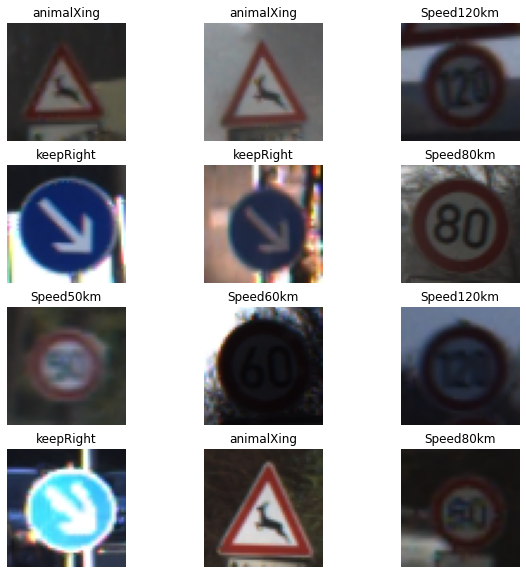

In [11]:
plt.figure(figsize=(10, 10))
for images, labels in trainDataset.take(1):
  for i in range(12):
    ax = plt.subplot(4, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Create datasets for model to train on.
The batch for the images should be shaped as (32x50x50x3)

In [12]:
for imageBatch, labelsBatch in trainDataset:
  image_batch_np = np.stack(list(imageBatch))
  labels_batch_np = np.stack(list(labelsBatch))
  break

print(image_batch_np.shape)
print(labels_batch_np.shape)

(32, 50, 50, 3)
(32,)


### prepare dataset for optimal training


shuffle and store the training and validation images in cache to try to prevent bottlenecks while during training

In [13]:
AUTOTUNE = tf.data.AUTOTUNE

trainDataset = trainDataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validationDataset = validationDataset.cache().prefetch(buffer_size=AUTOTUNE)

### Normalization Layer

The last column of the image batch are the color channel values, represented in range 0x00 - 0xFF. Rescale the values to be between zero and 1 for the normaization layer

note(this is a exerimental function in keras and is considered volatile)

In [14]:
normalizationLayer = layers.experimental.preprocessing.Rescaling(1./255)

Apply rescaled layer to the dataset

In [15]:
normalizedDataset = trainDataset.map(lambda x, y: (normalizationLayer(x), y))
image_batch_np, labels_batch_np = next(iter(normalizedDataset))
first_image = image_batch_np[0]

print(np.min(first_image), np.max(first_image)) 

0.047058795 1.0


### Data augmentation

Augment the training data to reduce overfitting

In [16]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomContrast(0.05, 
                                                 input_shape=( resizeHeight, 
                                                              resizeWidth,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

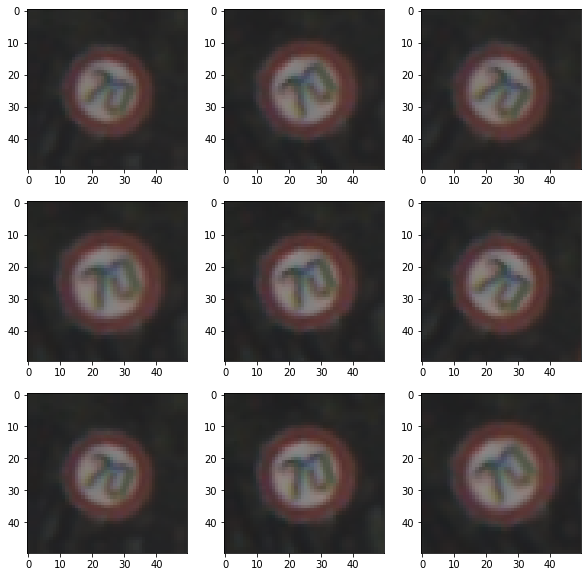

In [17]:
plt.figure(figsize=(10, 10))
for images, _ in trainDataset.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))

### Dropout

add the dropout layer and data augmentation layers

In [18]:
numberClasses = 23
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(numberClasses)
])

### Compile and train the model

In [19]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [20]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 50, 50, 3)         0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 50, 50, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 50, 50, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 25, 25, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 25, 25, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 64)       

In [21]:
epochs = 15
history = model.fit(
  trainDataset,
  validation_data=validationDataset,
  epochs=epochs
)

Epoch 1/15
588/588 [==============================] - 71s 119ms/step - loss: 2.1467 - accuracy: 0.3319 - val_loss: 0.7209 - val_accuracy: 0.7525
Epoch 2/15
588/588 [==============================] - 66s 112ms/step - loss: 0.7338 - accuracy: 0.7623 - val_loss: 0.2765 - val_accuracy: 0.9113
Epoch 3/15
588/588 [==============================] - 67s 114ms/step - loss: 0.3672 - accuracy: 0.8826 - val_loss: 0.1379 - val_accuracy: 0.9577
Epoch 4/15
588/588 [==============================] - 67s 114ms/step - loss: 0.2394 - accuracy: 0.9267 - val_loss: 0.0875 - val_accuracy: 0.9745
Epoch 5/15
588/588 [==============================] - 68s 115ms/step - loss: 0.1703 - accuracy: 0.9446 - val_loss: 0.0613 - val_accuracy: 0.9821
Epoch 6/15
588/588 [==============================] - 65s 111ms/step - loss: 0.1364 - accuracy: 0.9575 - val_loss: 0.0449 - val_accuracy: 0.9870
Epoch 7/15
588/588 [==============================] - 67s 113ms/step - loss: 0.1282 - accuracy: 0.9611 - val_loss: 0.0514 - val_ac

## Visualize training results

After applying data augmentation and Dropout, there is less overfitting than before, and training and validation accuracy are closer aligned. 

In [26]:
accuracy = history.history['accuracy']
validationAccuracy = history.history['val_accuracy']
loss = history.history['loss']
validLoss = history.history['val_loss']
epochsRange = range(epochs)

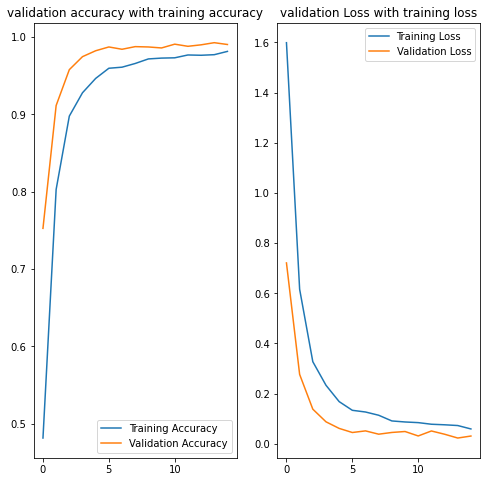

In [27]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochsRange, accuracy, label='Training Accuracy')
plt.plot(epochsRange, validationAccuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('validation accuracy with training accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochsRange, loss, label='Training Loss')
plt.plot(epochsRange, validLoss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('validation Loss with training loss')
plt.show()

### Prediction

Use the model to predict a ramdomly selected test image

In [32]:
import random

testlist = list(glob.glob(testDirectory+ '*.png'))

randimage = random.randint(0, (len(testlist)))

randimage = random.randint(0, (len(testlist)))
randimage =str(randimage)
randimage =(randimage.zfill(5))

testpath = (testDirectory + str(randimage) + '.png')
print(testpath)

C:/Users/Jeff/Desktop/GTSDS/test/01454.png


In [33]:

img = keras.preprocessing.image.load_img(
    testpath, target_size=(resizeHeight, resizeWidth)
)
imageArray = keras.preprocessing.image.img_to_array(img)
imageArray = tf.expand_dims(imageArray, 0) # Create a batch

predictions = model.predict(imageArray)
score = tf.nn.softmax(predictions[0])

print(100 * np.max(score), "%")
print(
    format(class_names[np.argmax(score)]))

Image.open(str(testpath))

99.9998927116394 %
Speed50km
